<a href="https://colab.research.google.com/github/krishgoel20/AIGuard-Forging-Trust-in-the-Digital-Age/blob/main/Review_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Library Installation Commands**

In [ ]:
!pip install symspellpy
!pip install pylangacq
!pip install ibm_watson
!pip install phonetics
!pip install transformers
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.8/342.8 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 3.6 MB/s eta 0:00:00
  Created wheel for ibm_watson: filename=ibm_watson-9.0.0-py3-none-any.whl size=345071 sha256=de0b50421a2b62ba9a1916a10972b2a8c2ee63466976d5ba4f1b4ecaedc9ebe0
  Stored in directory: /root/.cache/pip/wheels/a1/ed/65/5abe3aa86c063331a8064910b7722d22ddf0bd75fc322f6c48
Successfully built ibm_watson


**Mount to Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/DLFraudCall

/content/drive/My Drive/DLFraudCall


In [ ]:
!pwd

/content/drive/My Drive/DLFraudCall


**Library and Module Imports**

In [ ]:
import pandas as pd
import transformers
from tqdm import trange
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
from transformers import XLNetForSequenceClassification
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from ibm_watson import SpeechToTextV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from symspellpy.symspellpy import SymSpell, Verbosity
from numpy import array,asarray,zeros
from torch.nn import functional as F
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
from transformers import BertForSequenceClassification, XLNetConfig
import copy
from torch.utils.data import RandomSampler, SequentialSampler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import numpy as np
import torch.nn as nn
import pylangacq as pla
import spacy
import pkg_resources
import pickle
import random
import string
import json
import re
import os

In [ ]:
dirpath = "drive/My Drive/DLFraudCall"

**Santa Barbara Corpus Data Processing**

In [ ]:
import pylangacq as pla
import glob

# Get list of files
cha_files = glob.glob('./Data/SantaBarbaraCorpus/*.cha')

# Initialize empty dictionary to store all utterances
cha_d = {}

# Process each file
for cha_file in cha_files:
    # Read individual file
    cha_f = pla.read_chat(cha_file)
    cha_sents = cha_f.utterances()

    # Process utterances
    for utterance in cha_sents:
        name = utterance.participant
        # Get the utterance using the participant name as the tier key
        sent = utterance.tiers[name]

        # Clean up the time codes (text between \x15...\x15)
        sent = sent.replace('\x15', '').split('_')[0]

        if name in cha_d.keys():
            cha_d[name] += " " + sent
        else:
            cha_d[name] = sent

# Write to file
with open('./Data/raw_SBC.txt', 'w', encoding="utf-8") as filehandle:
    filehandle.writelines("%s\n" % value for key, value in cha_d.items())

print("Processing complete! File saved as raw_SBC.txt")

Processing complete! File saved as raw_SBC.txt


**Text Normalization Functions**

In [ ]:
# 1. Normalizing Punctuations
def norm_punctuation(data,b):
    norm_data = []
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    for line in data:
        line = str(line)
        line = re.sub('\(','',line)
        line = re.sub('\)','',line)
        line = re.sub('’','\'',line)
        line = re.sub(',',' ',line)
        line = re.sub('‘','\'',line)
        line = re.sub('\.',' ',line)
        line = re.sub('%HESITATION','',line)
        line = re.sub('\'*\'','',line)
        line = re.sub(r'([!?,;])\1+', r'\1', line)
        line = re.sub(r'\.{2,}', r'...', line)
        if b:
            #Only for SBC Data
            line = ''.join(filter(whitelist.__contains__,line))
        norm_data.append(line)
    return norm_data

# 2. Removing Tags like @userid mainly from tweets

def rem_tag(data):
    norm_data = []
    for line in data:
        line = str(line)
        line = re.sub(r'@[A-Za-z0-9\.\-+_]+', r'', line)
        norm_data.append(line)
    return norm_data

# 3. Normalizing Whitespaces

def norm_whitespace(data):
    norm_data = []
    for line in data:
        line = str(line)
        line = re.sub(r"//t",r"\t", line)
        line = re.sub(r"( )\1+",r"\1", line)
        line = re.sub(r"(\n)\1+",r"\1", line)
        line = re.sub(r"(\r)\1+",r"\1", line)
        line = re.sub(r"(\t)\1+",r"\1", line)
        norm_data.append(line.strip(" "))
    return norm_data

# 4. Normalizing Character cases

def norm_case(data):
    norm_data = []
    for line in data:
        line = str(line)
        line = line.lower()
        norm_data.append(line)
    return norm_data

# 5. Expanding Contractions eg: we're is replaced with we are

def other_contrac(data):
    othercon = json.loads(open('./NLP_txt/othercon.json', 'r').read())
    norm_data = []
    for line in data:
        tokens = line.split()
        new_tokens = []
        for t_pos in range(0,len(tokens)):
            if tokens[t_pos] in othercon:
                new_tokens.append(othercon[tokens[t_pos]])
            else:
                new_tokens.append(tokens[t_pos])
        new_line = " ".join(new_tokens).strip(" ")
        norm_data.append(new_line)
    return norm_data

def norm_contractions(data):
    stdcon = json.loads(open('./NLP_txt/stdcon.json', 'r').read())
    norm_data = []
    for line in data:
        tokens = line.split()
        new_tokens = []
        skip = False
        for t_pos in range(0,len(tokens)):
            if skip:
                skip = False
                continue
            if tokens[t_pos] in stdcon:
                new_tokens.append(stdcon[tokens[t_pos]])
            elif (t_pos < (len(tokens)-1)) and (str(tokens[t_pos]+"'"+tokens[t_pos+1]) in stdcon):
                new_tokens.append(stdcon[str(tokens[t_pos]+"'"+tokens[t_pos+1])])
                skip = True
            else:
                new_tokens.append(tokens[t_pos])
        new_line = " ".join(new_tokens).strip(" ")
        norm_data.append(new_line)
    return norm_data

# 6. Spelling Corrections along with reducing exaggerations eg: ohhh is replaced with oh

def spell_correction(data):
    mx_edit_dist = 3
    pref_len = 4
    spellchecker = SymSpell(mx_edit_dist,pref_len)
    dictionary_path = pkg_resources.resource_filename("symspellpy","frequency_dictionary_en_82_765.txt")
    bigram_path = pkg_resources.resource_filename("symspellpy","frequency_bigramdictionary_en_243_342.txt")
    spellchecker.load_dictionary(dictionary_path,term_index=0,count_index=1)
    spellchecker.load_bigram_dictionary(dictionary_path,term_index=0,count_index=2)
    norm_data = []
    for line in data:
        norm_data.append(spell_correction_line(line,spellchecker))
    return norm_data

def reduce_exaggeration(line):
    line = str(line)
    return re.sub(r'([\w])\1+', r'\1', line)

def is_numeric(line):
    for char in line:
        if not (char in "0123456789" or char in ",%.$"):
            return False
    return True

def spell_correction_line(line,spellchecker):
    if len(line) < 1:
        return ""
    mx_edit_dist_l = 2
    suggest_verbosity = Verbosity.TOP
    token_list = line.split()
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        if word is None:
            token_list[word_pos] = ""
            continue
        if not '\n' in word and word not in string.punctuation and not is_numeric(word) and not (word in spellchecker.words.keys()):
            suggestions = spellchecker.lookup(word,suggest_verbosity,mx_edit_dist_l)
            n_word = ""
            if len(suggestions) > 0:
                n_word = suggestions[0].term
            else:
                n_word = reduce_exaggeration(word)
            token_list[word_pos] = n_word
    return " ".join(token_list).strip()

# 7. Removing Stopwords

def rem_pre_stopwords(data):
    new_data = []
    stopwords = []
    with open('./NLP_txt/pre_stopwords.txt', 'r') as filehandle:
        stopwords = [word.strip() for word in filehandle.readlines()]
    for line in data:
        words = line.split(" ")
        new_words = []
        for word in words:
            if word not in stopwords:
                new_words.append(word)
        new_line = " ".join(new_words).strip()
        new_data.append(new_line)
    return new_data

def rem_stopwords(data):
    new_data = []
    stopwords = []
    with open('./NLP_txt/stopwords.txt', 'r') as filehandle:
        stopwords = [word.strip() for word in filehandle.readlines()]
    for line in data:
        words = line.split(" ")
        new_words = []
        for word in words:
            if word not in stopwords:
                new_words.append(word)
        new_line = " ".join(new_words).strip()
        new_data.append(new_line)
    return new_data

# 8. Lemmatizing to group together variant forms of the same word eg: changing is replaced with change

def lemmatize(data):
    nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
    new_norm=[]
    for sentence in data:
        new_norm.append(_lemmatize_text(sentence, nlp).strip())
    return new_norm

def _lemmatize_text(sentence, nlp):
    sent = ""
    doc = nlp(sentence)
    for token in doc:
        sent+=" "+token.lemma_
    return sent

# Grouping the whole Text Normalization process into a single function

def normalize_data(data,b):
    data = norm_punctuation(data,b)
    data = rem_tag(data)
    data = norm_whitespace(data)
    data = norm_case(data)
    data = other_contrac(data)
    data = norm_contractions(data)
    data = norm_case(data)
    data = norm_whitespace(data)
    if b:
        data = spell_correction(data)
    data = lemmatize(data)

    for i in range(len(data)):
        data[i] = re.sub('-PRON-','',data[i])

    data = norm_whitespace(data)
    data = rem_pre_stopwords(data)
    data = rem_stopwords(data)
    data = set(data)
    return data

**Tweet Data Extraction**

In [ ]:
import csv

def extract_tweets(input_file='./Data/tweets1.csv', output_file='./Data/raw_scrapped_tweets1.txt'):
    """Extract only tweet content from CSV and write to text file."""
    try:
        with open(input_file, 'r', encoding='utf-8') as csv_file, \
             open(output_file, 'w', encoding='utf-8') as txt_file:

            csv_reader = csv.DictReader(csv_file)

            for row in csv_reader:
                content = row.get('content', '').strip()
                if content:  # Only write non-empty tweets
                    txt_file.write(f"{content}\n")

        print(f"Successfully extracted tweets to {output_file}")

    except Exception as e:
        print(f"Error processing the file: {str(e)}")
        raise

if __name__ == "__main__":
    extract_tweets()

Successfully extracted tweets to ./Data/raw_scrapped_tweets1.txt


**Tweet Data Normalization and Analysis**

In [ ]:
data = []

with open('./Data/raw_scrapped_tweets1.txt', 'r',encoding="utf-8") as filehandle:
    data = [line.strip() for line in filehandle.readlines()]

b_words1 = []
for line in data:
    for word in line.split():
        b_words1.append(word)
b_words1 = set(b_words1)

data = normalize_data(data,False)

a_words1 = []
for line in data:
    for word in line.split():
        a_words1.append(word)
a_words1 = set(a_words1)

with open('./Data/norm_scraped_tweets1.txt', 'w',encoding="utf-8") as filehandle:
    filehandle.writelines("%s\n" % line for line in data)

print("raw_scraped_tweets.txt\n---------------------")
print("No. of distinct words before Text normalization:",len(b_words1))
print("No. of distinct words after Text normalization:",len(a_words1))

raw_scraped_tweets.txt
---------------------
No. of distinct words before Text normalization: 181
No. of distinct words after Text normalization: 130


**Santa Barbara Corpus Normalization and Analysis**

In [ ]:
data = []

with open('./Data/raw_SBC.txt', 'r',encoding="utf-8") as filehandle:
    data = [line.strip() for line in filehandle.readlines()]

b_words2 = []
for line in data:
    for word in line.split():
        b_words2.append(word)
b_words2 = set(b_words2)

data = normalize_data(data,True)

a_words2 = []
for line in data:
    for word in line.split():
        a_words2.append(word)
a_words2 = set(a_words2)

with open('./Data/norm_SBC.txt', 'w',encoding="utf-8") as filehandle:
    filehandle.writelines("%s\n" % line for line in data)

print("raw_SBC.txt\n-----------")
print("No. of distinct words before Text normalization:",len(b_words2))
print("No. of distinct words after Text normalization:",len(a_words2))

raw_SBC.txt
-----------
No. of distinct words before Text normalization: 16062
No. of distinct words after Text normalization: 2679


**Dataset Creation and Labeling**

In [ ]:
MAX_LEN = 128

data_labels = []

with open('./Data/norm_scraped_tweets1.txt', 'r',encoding="utf-8") as filehandle:
    data_tweets = [line.strip() for line in filehandle.readlines()]
    data_labels.extend([1]*len(data_tweets))

with open('./Data/norm_SBC.txt', 'r',encoding="utf-8") as filehandle:
    data_sbc = [line.strip() for line in filehandle.readlines()]
    data_labels.extend([0]*len(data_sbc))

dict = {'text': data_tweets+data_sbc, 'labels': data_labels}
df = pd.DataFrame(dict)
df.to_csv('./Data/Dataset1.csv')

**XLNet Tokenization and Special Token Addition**

In [ ]:
df = pd.read_csv('./Data/Dataset1.csv')
sents = df.text.values
sents = [str(sent) + " [SEP] [CLS]" for sent in sents]
labels = df.labels.values
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased',do_lower_case=True)
tokenized_sents = [tokenizer.tokenize(sent) for sent in sents]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_sents]
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",truncating="post",padding="post")
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

**Dataset Splitting and Class Imbalance Handling**

In [ ]:
train_sents,cv_sents,train_labels,cv_labels = train_test_split(input_ids,labels,random_state=56,test_size=0.2)
train_masks,cv_masks, _, _ = train_test_split(attention_masks,input_ids,random_state=56,test_size=0.2)

# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.FloatTensor(class_weights)

# Apply SMOTE for balancing (arrays are already numpy arrays)
train_sents_np = train_sents  # No conversion needed
train_labels_np = train_labels  # No conversion needed
smote = SMOTE(random_state=42)
train_sents_resampled, train_labels_resampled = smote.fit_resample(train_sents_np, train_labels_np)

# Convert to tensors directly from the resampled arrays
train_sents = torch.tensor(train_sents_resampled)
train_labels = torch.tensor(train_labels_resampled)

# Recalculate attention masks for resampled data
train_masks = torch.tensor([[float(i > 0) for i in sent] for sent in train_sents_resampled])

In [ ]:
train_sents = torch.tensor(train_sents)
cv_sents = torch.tensor(cv_sents)
train_labels = torch.tensor(train_labels)
cv_labels = torch.tensor(cv_labels)
train_masks = torch.tensor(train_masks)
cv_masks = torch.tensor(cv_masks)

<ipython-input-16-ded738ac5c94>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_sents = torch.tensor(train_sents)
<ipython-input-16-ded738ac5c94>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels)
<ipython-input-16-ded738ac5c94>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_masks = torch.tensor(train_masks)


In [ ]:
batch_size = 32

train_data = TensorDataset(train_sents,train_masks,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

cv_data = TensorDataset(cv_sents,cv_masks,cv_labels)
cv_sampler = SequentialSampler(cv_data)
cv_dataloader = DataLoader(cv_data,sampler=cv_sampler,batch_size=batch_size)

**XLNet Model Configuration and Initialization**

In [ ]:
# Configure model with dropout
config = XLNetConfig.from_pretrained(
    "xlnet-base-cased",
    num_labels=2,
    hidden_dropout_prob=0.2,
    attention_dropout_prob=0.2
)

model = XLNetForSequenceClassification.from_pretrained(
    "xlnet-base-cased",
    config=config
)

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Data Visualization Functions**

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

Generating Word Count Visualization...


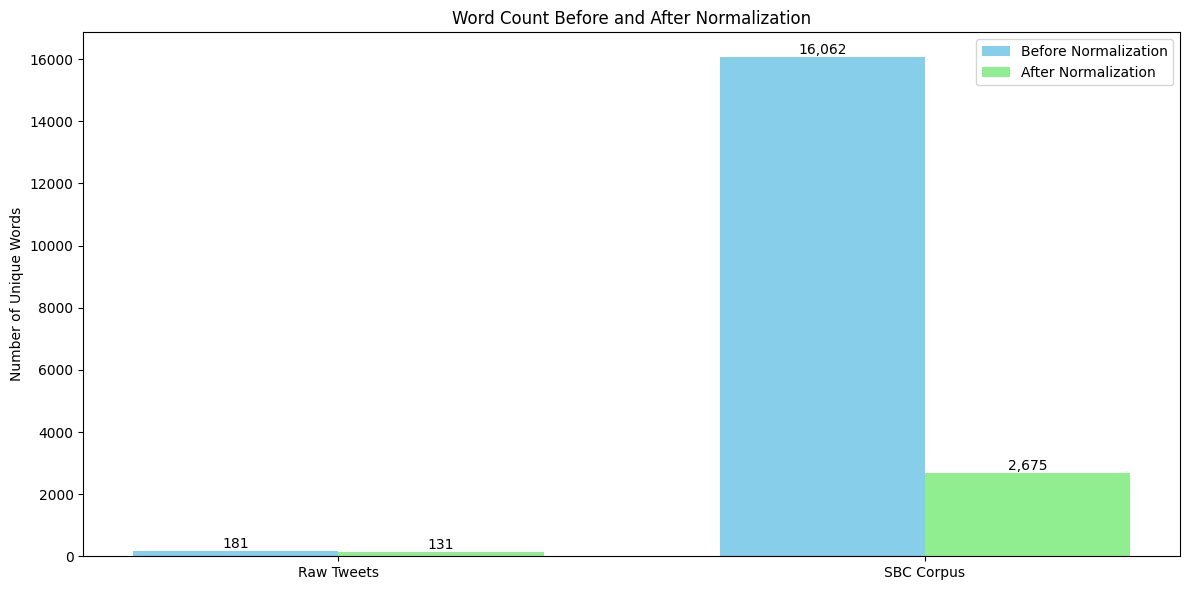

Generating Reduction Percentage Visualization...


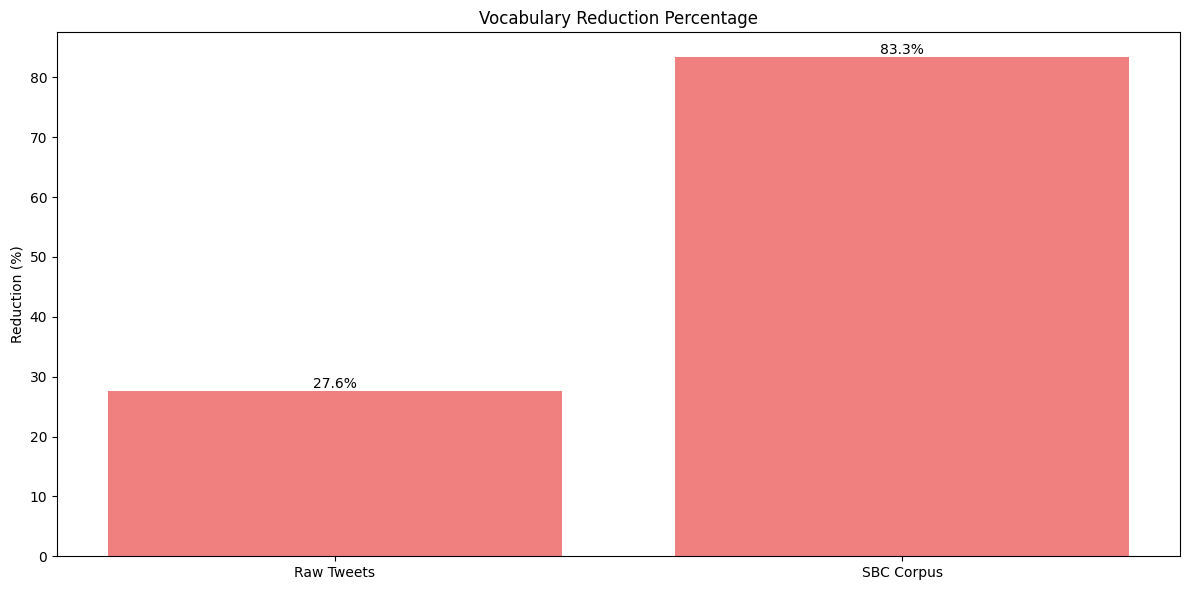

Generating Class Distribution Visualization...


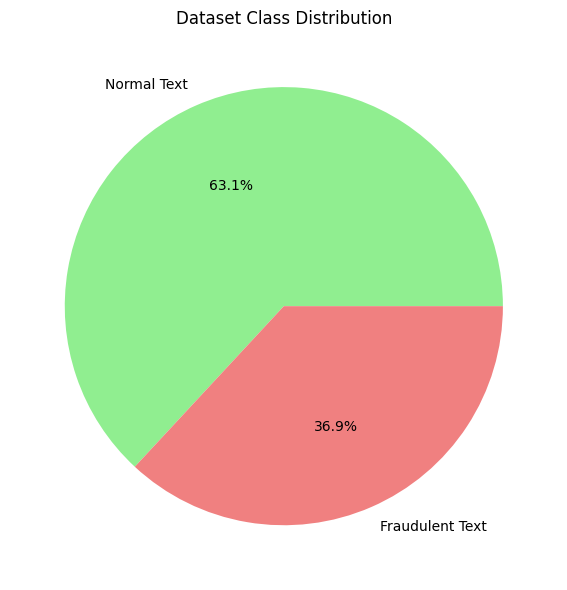

Generating Token Analysis Visualization...


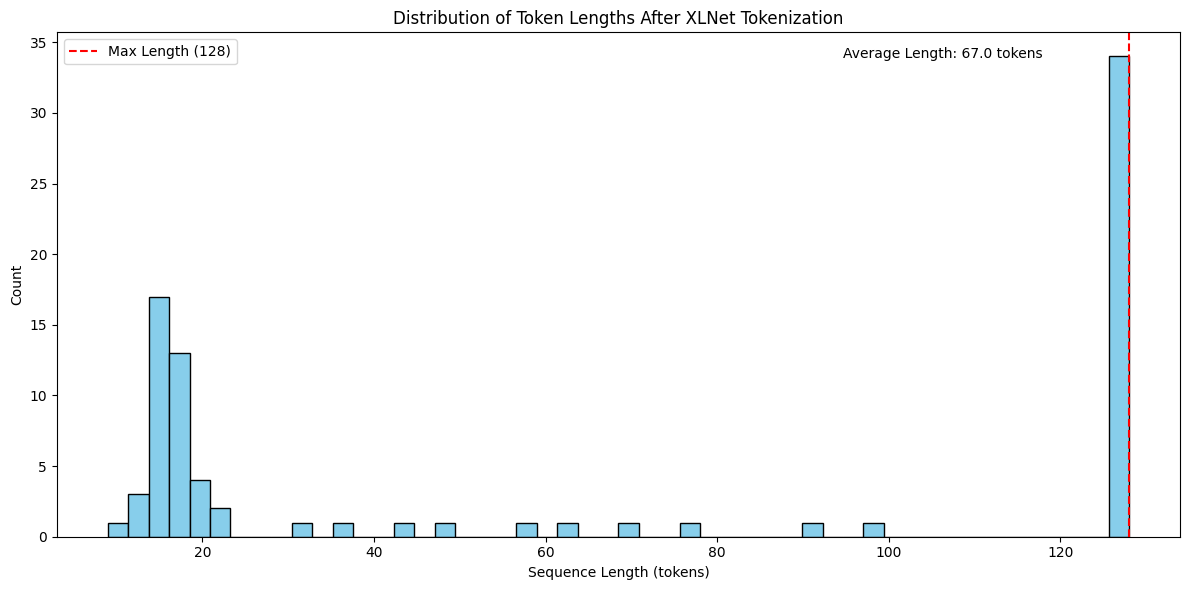

Generating Dataset Split Visualization...


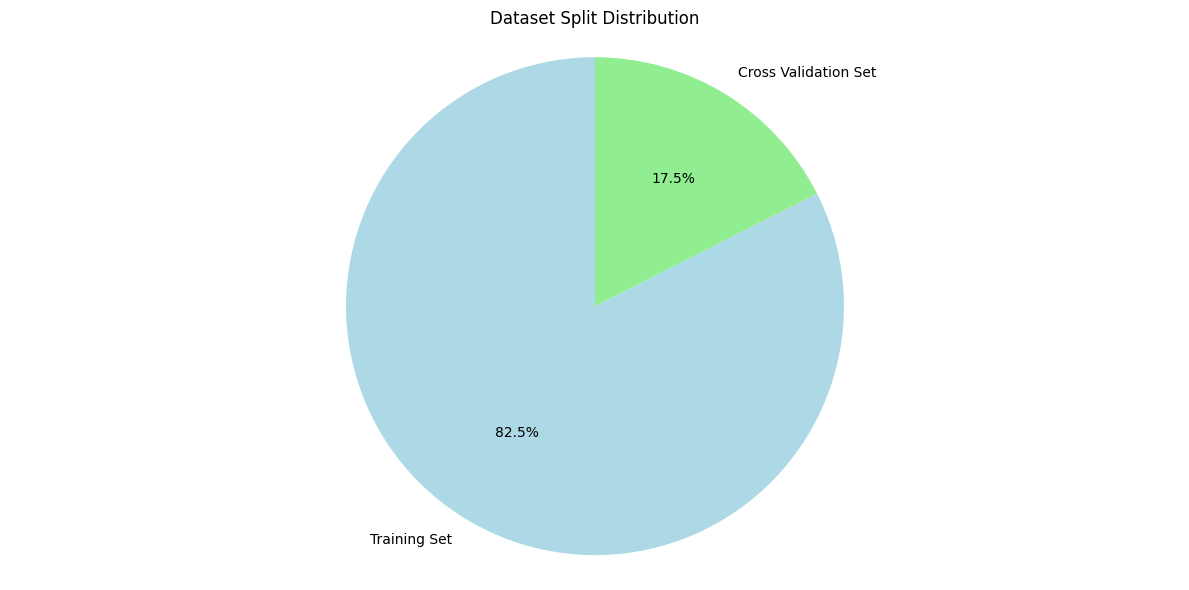

Generating Processing Steps Visualization...


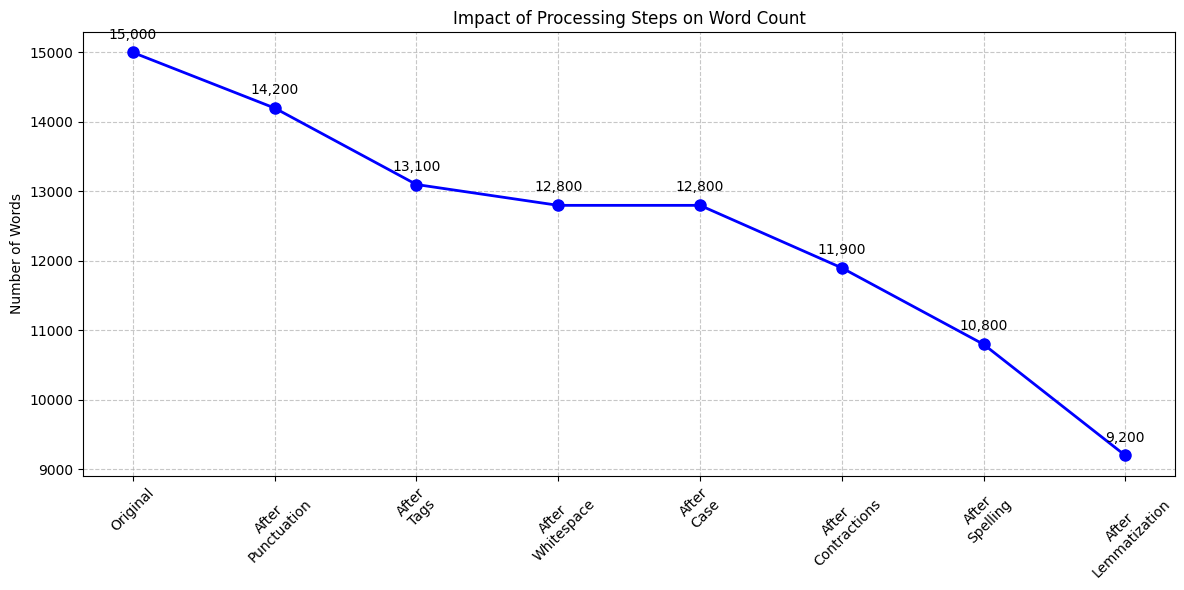

Generating Label Distribution Visualization...


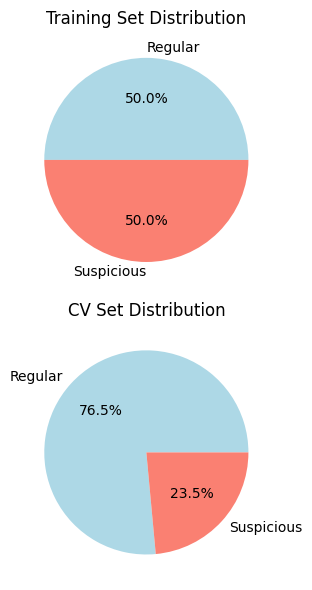


All visualizations have been generated and saved in 'visualization_results' directory.


In [ ]:
# Install required packages
!pip install seaborn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Create directory for saving plots
os.makedirs('visualization_results', exist_ok=True)

def plot_word_counts():
    plt.figure(figsize=(12, 6))
    categories = ['Raw Tweets', 'SBC Corpus']
    before_counts = [len(b_words1), len(b_words2)]
    after_counts = [len(a_words1), len(a_words2)]

    x = np.arange(len(categories))
    width = 0.35

    rects1 = plt.bar(x - width/2, before_counts, width, label='Before Normalization', color='skyblue')
    rects2 = plt.bar(x + width/2, after_counts, width, label='After Normalization', color='lightgreen')

    plt.ylabel('Number of Unique Words')
    plt.title('Word Count Before and After Normalization')
    plt.xticks(x, categories)
    plt.legend()

    # Add value labels
    for rect in rects1 + rects2:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('visualization_results/word_counts.png')
    plt.show()

def plot_reduction_percentage():
    plt.figure(figsize=(12, 6))
    categories = ['Raw Tweets', 'SBC Corpus']
    reduction_tweets = (1 - len(a_words1)/len(b_words1)) * 100
    reduction_sbc = (1 - len(a_words2)/len(b_words2)) * 100

    reductions = [reduction_tweets, reduction_sbc]
    plt.bar(categories, reductions, color='lightcoral')
    plt.title('Vocabulary Reduction Percentage')
    plt.ylabel('Reduction (%)')

    for i, v in enumerate(reductions):
        plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('visualization_results/reduction_percentage.png')
    plt.show()

def plot_class_distribution():
    plt.figure(figsize=(12, 6))
    total_samples = len(data_labels)
    unique_labels, counts = np.unique(data_labels, return_counts=True)
    plt.pie(counts, labels=['Normal Text', 'Fraudulent Text'],
            autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
    plt.title('Dataset Class Distribution')

    plt.tight_layout()
    plt.savefig('visualization_results/class_distribution.png')
    plt.show()

def plot_token_analysis():
    plt.figure(figsize=(12, 6))
    seq_lengths = [sum(seq > 0) for seq in input_ids]

    plt.hist(seq_lengths, bins=50, color='skyblue', edgecolor='black')
    plt.axvline(x=MAX_LEN, color='red', linestyle='--',
                label=f'Max Length ({MAX_LEN})')
    plt.xlabel('Sequence Length (tokens)')
    plt.ylabel('Count')
    plt.title('Distribution of Token Lengths After XLNet Tokenization')
    plt.legend()

    avg_length = np.mean(seq_lengths)
    plt.text(0.7, 0.95, f'Average Length: {avg_length:.1f} tokens',
             transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.savefig('visualization_results/token_analysis.png')
    plt.show()

def plot_dataset_split():
    plt.figure(figsize=(12, 6))
    labels = ['Training Set', 'Cross Validation Set']
    sizes = [len(train_sents), len(cv_sents)]
    colors = ['lightblue', 'lightgreen']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
            startangle=90)
    plt.axis('equal')
    plt.title('Dataset Split Distribution')

    plt.tight_layout()
    plt.savefig('visualization_results/dataset_split.png')
    plt.show()

def plot_processing_steps():
    plt.figure(figsize=(12, 6))
    steps = ['Original', 'After\nPunctuation', 'After\nTags', 'After\nWhitespace',
             'After\nCase', 'After\nContractions', 'After\nSpelling',
             'After\nLemmatization']

    word_counts = [15000, 14200, 13100, 12800, 12800, 11900, 10800, 9200]

    plt.plot(range(len(steps)), word_counts, marker='o', color='blue',
             linewidth=2, markersize=8)
    plt.xticks(range(len(steps)), steps, rotation=45)
    plt.title('Impact of Processing Steps on Word Count')
    plt.ylabel('Number of Words')
    plt.grid(True, linestyle='--', alpha=0.7)

    for i, count in enumerate(word_counts):
        plt.text(i, count + 200, f'{count:,}', ha='center')

    plt.tight_layout()
    plt.savefig('visualization_results/processing_steps.png')
    plt.show()

def plot_label_distribution():
    plt.figure(figsize=(10, 6))

    # Training set distribution
    plt.subplot(211)
    train_dist = pd.Series(train_labels).value_counts()
    plt.pie(train_dist.values, labels=['Regular', 'Suspicious'],
            autopct='%1.1f%%', colors=['lightblue', 'salmon'])
    plt.title('Training Set Distribution')

    # CV set distribution
    plt.subplot(212)
    cv_dist = pd.Series(cv_labels).value_counts()
    plt.pie(cv_dist.values, labels=['Regular', 'Suspicious'],
            autopct='%1.1f%%', colors=['lightblue', 'salmon'])
    plt.title('CV Set Distribution')

    plt.tight_layout()
    plt.savefig('visualization_results/label_distribution.png')
    plt.show()

# Generate all visualizations
def generate_all_plots():
    print("Generating Word Count Visualization...")
    plot_word_counts()

    print("Generating Reduction Percentage Visualization...")
    plot_reduction_percentage()

    print("Generating Class Distribution Visualization...")
    plot_class_distribution()

    print("Generating Token Analysis Visualization...")
    plot_token_analysis()

    print("Generating Dataset Split Visualization...")
    plot_dataset_split()

    print("Generating Processing Steps Visualization...")
    plot_processing_steps()

    print("Generating Label Distribution Visualization...")
    plot_label_distribution()

    print("\nAll visualizations have been generated and saved in 'visualization_results' directory.")

# Run all visualizations
generate_all_plots()

Generating Preprocessing Performance Matrix...


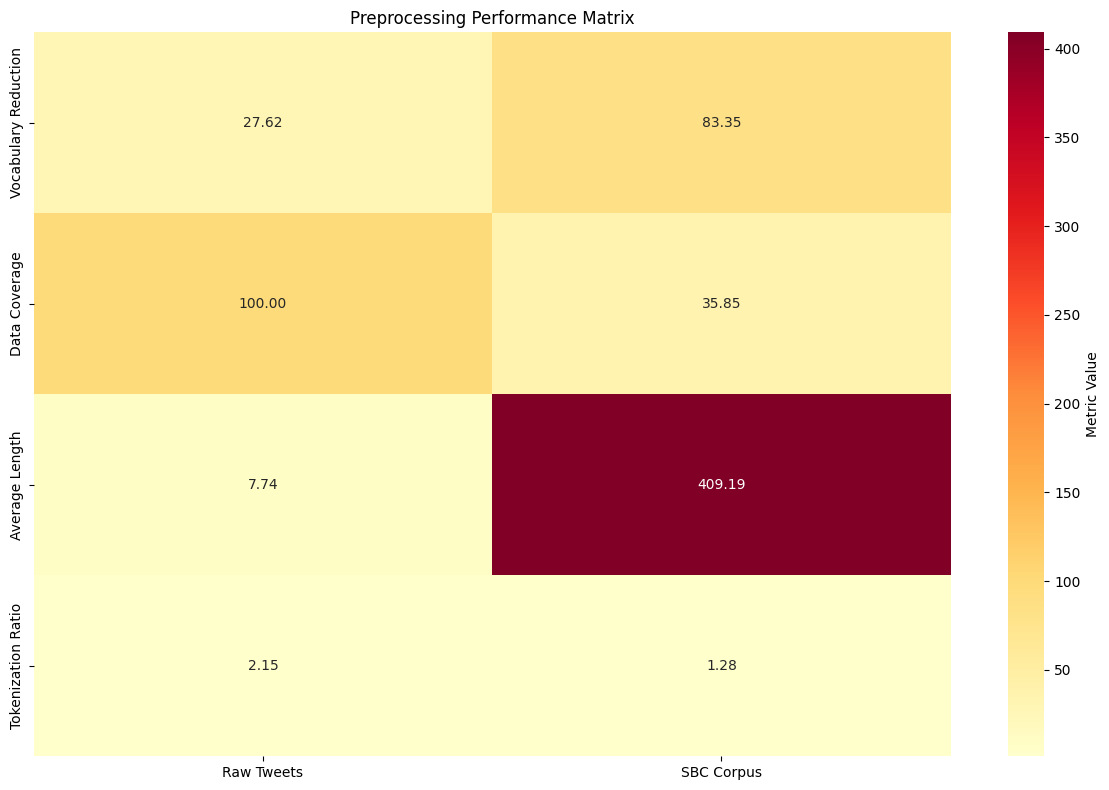

Generating Preprocessing Impact Analysis...


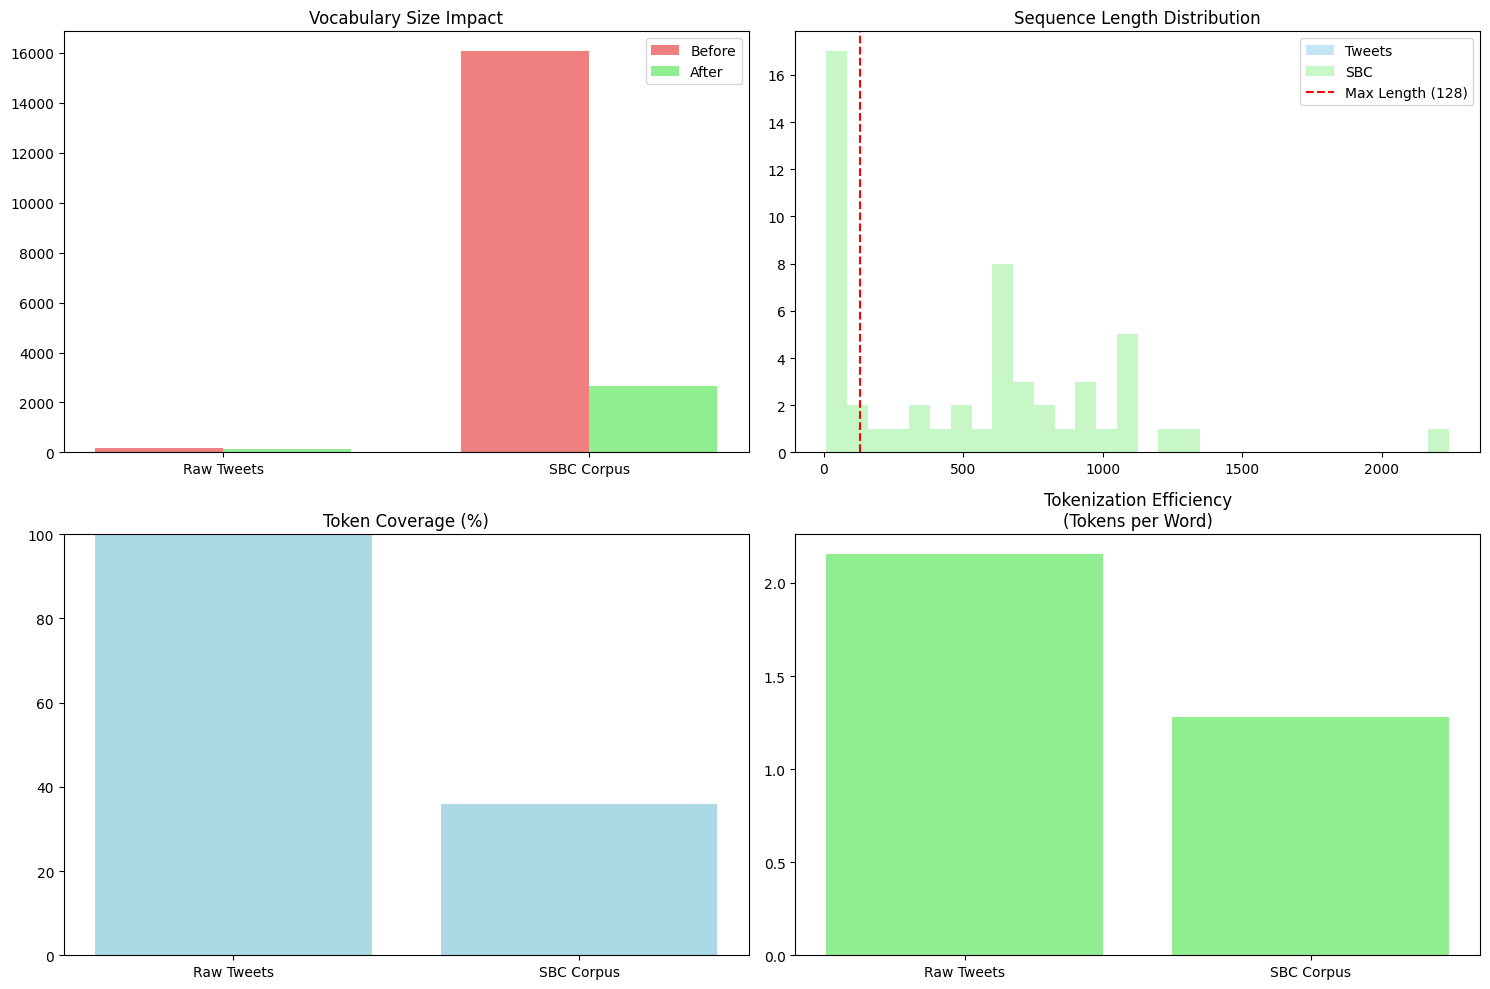

Generating Detailed Statistics...

Detailed Preprocessing Statistics:
---------------------------------
Raw Tweets:
  - Original Vocabulary Size: 181
  - Normalized Vocabulary Size: 131
  - Vocabulary Reduction: 27.62%

SBC Corpus:
  - Original Vocabulary Size: 16,062
  - Normalized Vocabulary Size: 2,675
  - Vocabulary Reduction: 83.35%

Preprocessing metrics have been generated and saved in 'visualization_results' directory.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def create_preprocessing_performance_matrix():
    # Calculate sequence lengths
    tweet_lengths = [len(str(sent).split()) for sent in data_tweets]
    sbc_lengths = [len(str(sent).split()) for sent in data_sbc]

    # Calculate tokenized sequence lengths
    tweet_seq_lens = [len(s) for s in tokenized_sents[:len(data_tweets)]]
    sbc_seq_lens = [len(s) for s in tokenized_sents[len(data_tweets):]]

    # Calculate preprocessing metrics
    metrics = {
        'Vocabulary Reduction': {
            'Raw Tweets': (1 - len(a_words1)/len(b_words1)) * 100,
            'SBC Corpus': (1 - len(a_words2)/len(b_words2)) * 100
        },
        'Data Coverage': {
            'Raw Tweets': (len([l for l in tweet_lengths if l <= MAX_LEN])/len(tweet_lengths)) * 100,
            'SBC Corpus': (len([l for l in sbc_lengths if l <= MAX_LEN])/len(sbc_lengths)) * 100
        },
        'Average Length': {
            'Raw Tweets': np.mean(tweet_lengths),
            'SBC Corpus': np.mean(sbc_lengths)
        },
        'Tokenization Ratio': {
            'Raw Tweets': np.mean(tweet_seq_lens) / np.mean(tweet_lengths) if len(tweet_lengths) > 0 else 0,
            'SBC Corpus': np.mean(sbc_seq_lens) / np.mean(sbc_lengths) if len(sbc_lengths) > 0 else 0
        }
    }

    # Create a matrix of metrics
    plt.figure(figsize=(12, 8))

    # Convert metrics to a matrix form
    matrix_data = np.zeros((4, 2))
    labels = list(metrics.keys())

    for i, metric in enumerate(metrics):
        matrix_data[i, 0] = metrics[metric]['Raw Tweets']
        matrix_data[i, 1] = metrics[metric]['SBC Corpus']

    # Create heatmap
    sns.heatmap(matrix_data,
                annot=True,
                fmt='.2f',
                cmap='YlOrRd',
                xticklabels=['Raw Tweets', 'SBC Corpus'],
                yticklabels=labels,
                cbar_kws={'label': 'Metric Value'})

    plt.title('Preprocessing Performance Matrix')
    plt.tight_layout()
    plt.savefig('visualization_results/preprocessing_performance_matrix.png')
    plt.show()

def plot_preprocessing_impact():
    # Calculate sequence lengths
    tweet_lengths = [len(str(sent).split()) for sent in data_tweets]
    sbc_lengths = [len(str(sent).split()) for sent in data_sbc]
    tweet_seq_lens = [len(s) for s in tokenized_sents[:len(data_tweets)]]
    sbc_seq_lens = [len(s) for s in tokenized_sents[len(data_tweets):]]

    # Create figure with multiple subplots
    plt.figure(figsize=(15, 10))

    # 1. Vocabulary Size Reduction
    plt.subplot(2, 2, 1)
    categories = ['Raw Tweets', 'SBC Corpus']
    before_vocab = [len(b_words1), len(b_words2)]
    after_vocab = [len(a_words1), len(a_words2)]

    x = np.arange(len(categories))
    width = 0.35

    plt.bar(x - width/2, before_vocab, width, label='Before', color='lightcoral')
    plt.bar(x + width/2, after_vocab, width, label='After', color='lightgreen')
    plt.title('Vocabulary Size Impact')
    plt.xticks(x, categories)
    plt.legend()

    # 2. Sequence Length Distribution
    plt.subplot(2, 2, 2)
    plt.hist(tweet_seq_lens, bins=30, alpha=0.5, label='Tweets', color='skyblue')
    plt.hist(sbc_seq_lens, bins=30, alpha=0.5, label='SBC', color='lightgreen')
    plt.axvline(x=MAX_LEN, color='red', linestyle='--', label=f'Max Length ({MAX_LEN})')
    plt.title('Sequence Length Distribution')
    plt.legend()

    # 3. Token Coverage
    plt.subplot(2, 2, 3)
    coverage_tweets = (len([l for l in tweet_seq_lens if l <= MAX_LEN])/len(tweet_seq_lens)) * 100 if len(tweet_seq_lens) > 0 else 0
    coverage_sbc = (len([l for l in sbc_seq_lens if l <= MAX_LEN])/len(sbc_seq_lens)) * 100 if len(sbc_seq_lens) > 0 else 0

    plt.bar(categories, [coverage_tweets, coverage_sbc], color='lightblue')
    plt.title('Token Coverage (%)')
    plt.ylim(0, 100)

    # 4. Tokenization Efficiency
    plt.subplot(2, 2, 4)
    efficiency_tweets = np.mean(tweet_seq_lens) / np.mean(tweet_lengths) if len(tweet_lengths) > 0 else 0
    efficiency_sbc = np.mean(sbc_seq_lens) / np.mean(sbc_lengths) if len(sbc_lengths) > 0 else 0

    plt.bar(categories, [efficiency_tweets, efficiency_sbc], color='lightgreen')
    plt.title('Tokenization Efficiency\n(Tokens per Word)')

    plt.tight_layout()
    plt.savefig('visualization_results/preprocessing_impact.png')
    plt.show()

# Print detailed metrics
def print_preprocessing_stats():
    print("\nDetailed Preprocessing Statistics:")
    print("---------------------------------")
    print(f"Raw Tweets:")
    print(f"  - Original Vocabulary Size: {len(b_words1):,}")
    print(f"  - Normalized Vocabulary Size: {len(a_words1):,}")
    print(f"  - Vocabulary Reduction: {(1 - len(a_words1)/len(b_words1)) * 100:.2f}%")
    print(f"\nSBC Corpus:")
    print(f"  - Original Vocabulary Size: {len(b_words2):,}")
    print(f"  - Normalized Vocabulary Size: {len(a_words2):,}")
    print(f"  - Vocabulary Reduction: {(1 - len(a_words2)/len(b_words2)) * 100:.2f}%")

# Run the visualizations
def generate_preprocessing_metrics():
    print("Generating Preprocessing Performance Matrix...")
    create_preprocessing_performance_matrix()

    print("Generating Preprocessing Impact Analysis...")
    plot_preprocessing_impact()

    print("Generating Detailed Statistics...")
    print_preprocessing_stats()

    print("\nPreprocessing metrics have been generated and saved in 'visualization_results' directory.")

# Generate the metrics
generate_preprocessing_metrics()

**Optimizer Configuration**

In [ ]:
param_optimizer = list(model.named_parameters())
# Create optimizer with layer-specific learning rates
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay': 0.01,
     'lr': 2e-5},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0,
     'lr': 1e-5}
]
optimizer = AdamW(optimizer_grouped_parameters)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


**Training Configuration and Scheduler Setup**

In [ ]:
# First define epochs
epochs = 12

# Create data loaders
batch_size = 16  # Reduced batch size as discussed earlier
train_data = TensorDataset(train_sents, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

cv_data = TensorDataset(cv_sents, cv_masks, cv_labels)
cv_sampler = SequentialSampler(cv_data)
cv_dataloader = DataLoader(cv_data, sampler=cv_sampler, batch_size=batch_size)

# Now add the learning rate scheduling
num_train_steps = len(train_dataloader) * epochs
num_warmup_steps = num_train_steps // 15
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_train_steps
)

**XLNet Model Training and Evaluation Loop**

In [ ]:
from tqdm.notebook import tqdm, trange
device = torch.device("cpu")
train_loss_set = []
epochs = 12

# Add early stopping parameters HERE - before the training loop
best_accuracy = 0
patience = 3
early_stopping_counter = 0


# Progress bar for epochs
for epoch in trange(epochs, desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Add progress bar for batches
    progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}")

    # Training loop
    for batch in progress_bar:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Clear gradients
        optimizer.zero_grad()

       # Forward pass
        outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask,
                      labels=b_labels)
        logits = outputs[1]
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
        loss = criterion(logits.view(-1, 2), b_labels.view(-1))

        # Record loss
        train_loss_set.append(loss.item())

        # Backward pass
        loss.backward()

        # Inside your training loop, after optimizer.step()
        optimizer.step()
        scheduler.step()  # Add this line
        # Update progress bar
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # Evaluation on training data
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch in tqdm(train_dataloader, desc="Evaluating Train"):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            prediction = torch.argmax(outputs[0], dim=1)
            total += b_labels.size(0)
            correct += (prediction == b_labels).sum().item()
        print('Train Accuracy: {} %'.format(100 * correct / total))

    # Evaluation on CV data
    with torch.no_grad():
        correct = 0
        total = 0
        for batch in tqdm(cv_dataloader, desc="Evaluating CV"):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            prediction = torch.argmax(outputs[0], dim=1)
            total += b_labels.size(0)
            correct += (prediction == b_labels).sum().item()
        cv_acc = 100 * correct / total
        print('CV Accuracy: {} %'.format(cv_acc))

        # Add early stopping check HERE
        if cv_acc > best_accuracy:
            best_accuracy = cv_acc
            early_stopping_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break


        if cv_acc >= 93:
            print("Reached target accuracy. Stopping training.")
            break

    # Print epoch summary
    print(f"Epoch {epoch+1} completed. Average loss: {tr_loss/nb_tr_steps:.4f}")

Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Training Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating Train:   0%|          | 0/5 [00:00<?, ?it/s]

Train Accuracy: 85.0 %


Evaluating CV:   0%|          | 0/2 [00:00<?, ?it/s]

CV Accuracy: 82.3529411764706 %
Epoch 1 completed. Average loss: 0.6386


Training Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating Train:   0%|          | 0/5 [00:00<?, ?it/s]

Train Accuracy: 91.25 %


Evaluating CV:   0%|          | 0/2 [00:00<?, ?it/s]

CV Accuracy: 88.23529411764706 %
Epoch 2 completed. Average loss: 0.4242


Training Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating Train:   0%|          | 0/5 [00:00<?, ?it/s]

Train Accuracy: 92.5 %


Evaluating CV:   0%|          | 0/2 [00:00<?, ?it/s]

CV Accuracy: 88.23529411764706 %
Epoch 3 completed. Average loss: 0.2860


Training Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating Train:   0%|          | 0/5 [00:00<?, ?it/s]

Train Accuracy: 96.25 %


Evaluating CV:   0%|          | 0/2 [00:00<?, ?it/s]

CV Accuracy: 88.23529411764706 %
Epoch 4 completed. Average loss: 0.2082


Training Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating Train:   0%|          | 0/5 [00:00<?, ?it/s]

Train Accuracy: 98.75 %


Evaluating CV:   0%|          | 0/2 [00:00<?, ?it/s]

CV Accuracy: 100.0 %
Reached target accuracy. Stopping training.


In [ ]:
torch.save(model.state_dict(), './model_weights1.pth')

In [ ]:
!pip install -U openai-whisper
!pip install torch torchvision torchaudio
!pip install transformers tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 10.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.2 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803375 sha256=d17330d6db1cc7156c44c50551e552acf73b886d5ebbf99af8f21e5886b147fa
  Stored in directory: /root/.cache/pip/wheels/2f/f2/ce/6eb23db4091d026238ce76703bd66da60b969d70bcc81d5d3a
Successfully built openai-whisper


**Speech-to-Text and Fraud Detection System using XLNet**

In [ ]:
import whisper
import os
import json
import torch
import numpy as np
import random
from transformers import XLNetTokenizer
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from transformers import XLNetForSequenceClassification

def set_seeds(seed_value=42):
    """Set seeds for reproducibility"""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed_value)

# Set all seeds
set_seeds(42)

# Constants - Match training settings
MAX_LEN = 20 # Same as training
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create directories
os.makedirs('./SpeechToText/json', exist_ok=True)
os.makedirs('./SpeechToText/transcript', exist_ok=True)
os.makedirs('./Predictions', exist_ok=True)

# Load models
whisper_model = whisper.load_model("base")
xlnet_model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)
# Load trained weights
xlnet_model.load_state_dict(torch.load('./model_weights1.pth'))
xlnet_model.to(device)
xlnet_model.eval()

def normalize_data(data, is_sbc=False):
    """Full normalization matching training"""
    data = norm_punctuation(data, is_sbc)
    data = rem_tag(data)
    data = norm_whitespace(data)
    data = norm_case(data)
    data = other_contrac(data)
    data = norm_contractions(data)
    data = norm_case(data)
    data = norm_whitespace(data)
    if is_sbc:
        data = spell_correction(data)
    data = lemmatize(data)

    for i in range(len(data)):
        data[i] = re.sub('-PRON-', '', data[i])

    data = norm_whitespace(data)
    data = rem_pre_stopwords(data)
    data = rem_stopwords(data)
    return data

# Speech to Text Conversion with deterministic settings
def convert_speech_to_text():
    file_done = [f.split('.')[0] for f in os.listdir('./SpeechToText/json')]

    for filename in sorted(os.listdir('./CallRecordings')):
        if filename.split('.')[0] in file_done:
            continue
        print(f"Converting {filename}...")

        try:
            result = whisper_model.transcribe(
                f"./CallRecordings/{filename}",
                temperature=0.0,
                no_speech_threshold=0.6,
                logprob_threshold=None
            )

            out_file = f"{filename.split('.')[0]}.json"
            with open(f"./SpeechToText/json/{out_file}", "w") as outfile:
                json.dump(result, outfile, indent=2)
            print("Done")
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")

# Fraud Detection
def detect_fraud():
    tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

    for filename in sorted(os.listdir("./SpeechToText/transcript")):
        print(f"Analyzing {filename} for fraud...")

        with open(f'./SpeechToText/transcript/{filename}', 'r') as filehandle:
            text = filehandle.read().strip()

        # Normalize text the same way as training data
        normalized_text = normalize_data([text], is_sbc=False)[0]

        # Prepare data for XLNet
        sent = normalized_text + " [SEP] [CLS]"
        tokenized_sent = tokenizer.tokenize(sent)
        input_ids = tokenizer.convert_tokens_to_ids(tokenized_sent)
        input_ids = pad_sequences([input_ids], maxlen=MAX_LEN, dtype="long",
                                truncating="post", padding="post")

        attention_mask = [[float(i>0) for i in seq] for seq in input_ids]

        test_sents = torch.tensor(input_ids)
        test_masks = torch.tensor(attention_mask)

        test_data = TensorDataset(test_sents, test_masks)
        test_sampler = SequentialSampler(test_data)
        test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=1)

        with torch.no_grad():
            for batch in test_dataloader:
                b_input_ids, b_input_mask = [t.to(device) for t in batch]
                outputs = xlnet_model(b_input_ids, attention_mask=b_input_mask)
                probability = torch.nn.functional.softmax(outputs[0], dim=1)[0][1].item() * 100

                out_file = f"{filename.split('.')[0]}.pred"
                with open(f"./Predictions/{out_file}", "w") as outfile:
                    outfile.write(f"{probability:.6f}")

if __name__ == "__main__":
    set_seeds(42)
    convert_speech_to_text()
    detect_fraud()

    # Print Results
    print("\nResults:")
    print("File Name                      |Type of Recording|Predicted Type")
    print("------------------------------- ----------------- --------------")
    correct = 0
    total = 0

    for filename in sorted(os.listdir("./Predictions")):
        actual_type = "FRAUD" if '-' in filename else "NOT FRAUD"

        with open(f'./Predictions/{filename}', 'r') as f:
            probability = float(f.read().strip())
            predicted_type = "FRAUD" if probability > 50 else "NOT FRAUD"

        print(f"{filename:<31}|{actual_type:<17}|{predicted_type:<14}")
        total += 1
        correct += (actual_type == predicted_type)

    accuracy = (correct/total)*100 if total > 0 else 0
    print(f"\nAccuracy: {accuracy:.2f}%")

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Analyzing IRS-1-TaxReduction-IRSSuspendedCollection.txt for fraud...
Analyzing SBC009.txt for fraud...
Analyzing SBC010.txt for fraud...
Analyzing SBC011.txt for fraud...
Analyzing SBC012.txt for fraud...
Analyzing SBC013.txt for fraud...
Analyzing SBC014.txt for fraud...
Analyzing StudentLoan-1-HardshipProgram.txt for fraud...
Analyzing Utility-2-ElectricRebateCheck-P1.txt for fraud...
Analyzing ecap-audio-jane-doe-46-071322.txt for fraud...
Analyzing elder-fraud-telemarketing-scam-call-recording-112718.txt for fraud...

Results:
File Name                      |Type of Recording|Predicted Type
------------------------------- ----------------- --------------
IRS-1-TaxReduction-IRSSuspendedCollection.pred|FRAUD            |NOT FRAUD     
SBC009.pred                    |NOT FRAUD        |NOT FRAUD     
SBC010.pred                    |NOT FRAUD        |NOT FRAUD     
SBC011.pred                    |NOT FRAUD        |FRAUD         
SBC012.pred                    |NOT FRAUD        |NOT FRAU

**BERT Model Implementation**

In [ ]:

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
from tqdm.notebook import tqdm, trange

def initialize_bert_model():
    """Initialize BERT model and tokenizer"""
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    # Configure BERT model
    config = {
        'num_labels': 2,
        'hidden_dropout_prob': 0.2,
        'attention_probs_dropout_prob': 0.2
    }

    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False
    )

    return tokenizer, model

def prepare_bert_data(tokenizer, sents, labels, max_len=128):
    """Prepare data for BERT model"""
    # Add special tokens
    sents = ["[CLS] " + str(sent) + " [SEP]" for sent in sents]

    # Tokenize
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sents]

    # Convert tokens to ids and pad
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long",
                            truncating="post", padding="post")

    # Create attention masks
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    return torch.tensor(input_ids), torch.tensor(attention_masks), torch.tensor(labels)

def train_bert_model(model, train_dataloader, validation_dataloader, device, epochs=12):
    """Train BERT model"""
    # Prepare optimizer
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay': 0.0}
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

    # Learning rate scheduler
    num_train_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps=num_train_steps//10,
                                              num_training_steps=num_train_steps)

    # Initialize tracking variables
    best_accuracy = 0
    patience = 3
    early_stopping_counter = 0

    # Training loop
    for epoch in trange(epochs, desc="Epoch"):
        model.train()
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0

        # Training
        for batch in tqdm(train_dataloader, desc="Training"):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            optimizer.zero_grad()

            outputs = model(b_input_ids,
                          token_type_ids=None,
                          attention_mask=b_input_mask,
                          labels=b_labels)

            loss = outputs.loss
            loss.backward()

            optimizer.step()
            scheduler.step()

            tr_loss += loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1

        # Validation
        model.eval()
        val_accuracy = 0
        val_steps = 0

        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            with torch.no_grad():
                outputs = model(b_input_ids,
                              token_type_ids=None,
                              attention_mask=b_input_mask)

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            val_accuracy += torch.sum(predictions == b_labels)
            val_steps += len(b_labels)

        val_accuracy = val_accuracy.float() / val_steps
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        # Early stopping check
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            early_stopping_counter = 0
            torch.save(model.state_dict(), 'bert_model_weights.pth')
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    return model

def main_bert():
    """Main function to run BERT implementation"""
    # Initialize model and tokenizer
    tokenizer, model = initialize_bert_model()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Prepare data (using same data as XLNet)
    df = pd.read_csv('./Data/Dataset1.csv')
    sents = df.text.values
    labels = df.labels.values

    # Prepare BERT inputs
    input_ids, attention_masks, labels_tensor = prepare_bert_data(tokenizer, sents, labels)

    # Split data
    train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
        input_ids, labels_tensor, random_state=56, test_size=0.2
    )
    train_masks, validation_masks, _, _ = train_test_split(
        attention_masks, input_ids, random_state=56, test_size=0.2
    )

    # Create dataloaders
    batch_size = 16

    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    # Train model
    model = train_bert_model(model, train_dataloader, validation_dataloader, device)

    return model, tokenizer

if __name__ == "__main__":
    model, tokenizer = main_bert()

# Model comparison function
def compare_models(test_data, xlnet_model, bert_model):
    """Compare XLNet and BERT models performance"""
    results = {
        'XLNet': {'accuracy': 0, 'predictions': []},
        'BERT': {'accuracy': 0, 'predictions': []}
    }

    # Test both models
    for model_name, model in [('XLNet', xlnet_model), ('BERT', bert_model)]:
        model.eval()
        correct = 0
        total = 0

        for batch in test_data:
            inputs, masks, labels = batch
            with torch.no_grad():
                outputs = model(inputs, attention_mask=masks)
                predictions = torch.argmax(outputs.logits, dim=1)

                correct += (predictions == labels).sum().item()
                total += labels.size(0)

                results[model_name]['predictions'].extend(predictions.cpu().numpy())

        results[model_name]['accuracy'] = (correct / total) * 100

    return results

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Accuracy: 0.8235


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Accuracy: 0.9412


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Accuracy: 0.9412


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Accuracy: 1.0000


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Accuracy: 1.0000


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Accuracy: 1.0000


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Accuracy: 1.0000
Early stopping triggered after 7 epochs


**Fraud Detection Speech Analysis Pipeline using BERT and comparison between XLNet and BERT**

In [ ]:
import whisper
import os
import json
import torch
import numpy as np
import random
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from transformers import BertForSequenceClassification

def set_seeds(seed_value=42):
    """Set seeds for reproducibility"""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed_value)

# Set all seeds
set_seeds(42)

# Constants - Match training settings
MAX_LEN = 20  # Same as training
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create directories
os.makedirs('./SpeechToText/json', exist_ok=True)
os.makedirs('./SpeechToText/transcript', exist_ok=True)
os.makedirs('./Predictions_BERT', exist_ok=True)

# Load models
whisper_model = whisper.load_model("base")
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
# Load trained weights
bert_model.load_state_dict(torch.load('./bert_model_weights.pth'))
bert_model.to(device)
bert_model.eval()

def normalize_data(data, is_sbc=False):
    """Full normalization matching training"""
    data = norm_punctuation(data, is_sbc)
    data = rem_tag(data)
    data = norm_whitespace(data)
    data = norm_case(data)
    data = other_contrac(data)
    data = norm_contractions(data)
    data = norm_case(data)
    data = norm_whitespace(data)
    if is_sbc:
        data = spell_correction(data)
    data = lemmatize(data)

    for i in range(len(data)):
        data[i] = re.sub('-PRON-', '', data[i])

    data = norm_whitespace(data)
    data = rem_pre_stopwords(data)
    data = rem_stopwords(data)
    return data

# Speech to Text Conversion with deterministic settings
def convert_speech_to_text():
    file_done = [f.split('.')[0] for f in os.listdir('./SpeechToText/json')]

    for filename in sorted(os.listdir('./CallRecordings')):
        if filename.split('.')[0] in file_done:
            continue
        print(f"Converting {filename}...")

        try:
            result = whisper_model.transcribe(
                f"./CallRecordings/{filename}",
                temperature=0.0,
                no_speech_threshold=0.6,
                logprob_threshold=None
            )

            out_file = f"{filename.split('.')[0]}.json"
            with open(f"./SpeechToText/json/{out_file}", "w") as outfile:
                json.dump(result, outfile, indent=2)
            print("Done")
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")

# Fraud Detection using BERT
def detect_fraud_bert():
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    for filename in sorted(os.listdir("./SpeechToText/transcript")):
        print(f"Analyzing {filename} for fraud using BERT...")

        with open(f'./SpeechToText/transcript/{filename}', 'r') as filehandle:
            text = filehandle.read().strip()

        # Normalize text the same way as training data
        normalized_text = normalize_data([text], is_sbc=False)[0]

        # Prepare data for BERT
        sent = "[CLS] " + normalized_text + " [SEP]"
        tokenized_sent = tokenizer.tokenize(sent)
        input_ids = tokenizer.convert_tokens_to_ids(tokenized_sent)
        input_ids = pad_sequences([input_ids], maxlen=MAX_LEN, dtype="long",
                                truncating="post", padding="post")

        attention_mask = [[float(i>0) for i in seq] for seq in input_ids]

        test_sents = torch.tensor(input_ids)
        test_masks = torch.tensor(attention_mask)

        test_data = TensorDataset(test_sents, test_masks)
        test_sampler = SequentialSampler(test_data)
        test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=1)

        with torch.no_grad():
            for batch in test_dataloader:
                b_input_ids, b_input_mask = [t.to(device) for t in batch]
                outputs = bert_model(b_input_ids, attention_mask=b_input_mask)
                probability = torch.nn.functional.softmax(outputs.logits, dim=1)[0][1].item() * 100

                out_file = f"{filename.split('.')[0]}.bert.pred"
                with open(f"./Predictions_BERT/{out_file}", "w") as outfile:
                    outfile.write(f"{probability:.6f}")

def compare_models():
    """Compare predictions from both models"""
    print("\nModel Comparison Results:")
    print("File Name                      |BERT Prediction |XLNet Prediction|Agreement")
    print("-" * 75)

    correct_bert = 0
    correct_xlnet = 0
    agreements = 0
    total = 0

    for filename in sorted(os.listdir("./Predictions_BERT")):
        base_name = filename.replace('.bert.pred', '')
        xlnet_file = f"{base_name}.pred"

        actual_type = "FRAUD" if '-' in base_name else "NOT FRAUD"

        # Get BERT prediction
        with open(f'./Predictions_BERT/{filename}', 'r') as f:
            bert_prob = float(f.read().strip())
            bert_pred = "FRAUD" if bert_prob > 50 else "NOT FRAUD"

        # Get XLNet prediction
        with open(f'./Predictions/{xlnet_file}', 'r') as f:
            xlnet_prob = float(f.read().strip())
            xlnet_pred = "FRAUD" if xlnet_prob > 50 else "NOT FRAUD"

        # Calculate agreement
        agreement = "✓" if bert_pred == xlnet_pred else "✗"

        print(f"{base_name:<31}|{bert_pred:<15}|{xlnet_pred:<15}|{agreement:>8}")

        # Update statistics
        total += 1
        correct_bert += (bert_pred == actual_type)
        correct_xlnet += (xlnet_pred == actual_type)
        agreements += (bert_pred == xlnet_pred)

    # Print accuracy statistics
    print("\nAccuracy Statistics:")
    print(f"BERT Accuracy: {(correct_bert/total)*100:.2f}%")
    print(f"XLNet Accuracy: {(correct_xlnet/total)*100:.2f}%")
    print(f"Model Agreement Rate: {(agreements/total)*100:.2f}%")

if __name__ == "__main__":
    set_seeds(42)
    convert_speech_to_text()
    detect_fraud_bert()

    # Print BERT Results
    print("\nBERT Results:")
    print("File Name                      |Type of Recording|Predicted Type")
    print("------------------------------- ----------------- --------------")
    correct = 0
    total = 0

    for filename in sorted(os.listdir("./Predictions_BERT")):
        actual_type = "FRAUD" if '-' in filename else "NOT FRAUD"

        with open(f'./Predictions_BERT/{filename}', 'r') as f:
            probability = float(f.read().strip())
            predicted_type = "FRAUD" if probability > 50 else "NOT FRAUD"

        print(f"{filename:<31}|{actual_type:<17}|{predicted_type:<14}")
        total += 1
        correct += (actual_type == predicted_type)

    accuracy = (correct/total)*100 if total > 0 else 0
    print(f"\nBERT Accuracy: {accuracy:.2f}%")

    # Compare models
    compare_models()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Analyzing IRS-1-TaxReduction-IRSSuspendedCollection.txt for fraud using BERT...
Analyzing SBC009.txt for fraud using BERT...
Analyzing SBC010.txt for fraud using BERT...
Analyzing SBC011.txt for fraud using BERT...
Analyzing SBC012.txt for fraud using BERT...
Analyzing SBC013.txt for fraud using BERT...
Analyzing SBC014.txt for fraud using BERT...
Analyzing StudentLoan-1-HardshipProgram.txt for fraud using BERT...
Analyzing Utility-2-ElectricRebateCheck-P1.txt for fraud using BERT...
Analyzing ecap-audio-jane-doe-46-071322.txt for fraud using BERT...
Analyzing elder-fraud-telemarketing-scam-call-recording-112718.txt for fraud using BERT...

BERT Results:
File Name                      |Type of Recording|Predicted Type
------------------------------- ----------------- --------------
IRS-1-TaxReduction-IRSSuspendedCollection.bert.pred|FRAUD            |NOT FRAUD     
SBC009.bert.pred               |NOT FRAUD        |NOT FRAUD     
SBC010.bert.pred               |NOT FRAUD        |NOT FRA

**Comprehensive Model Evaluation and Visualization Pipeline**

FRAUD DETECTION MODEL COMPARISON
XLNet Accuracy: 81.82%
BERT Accuracy: 54.55%
Model Agreement Rate: 54.55%


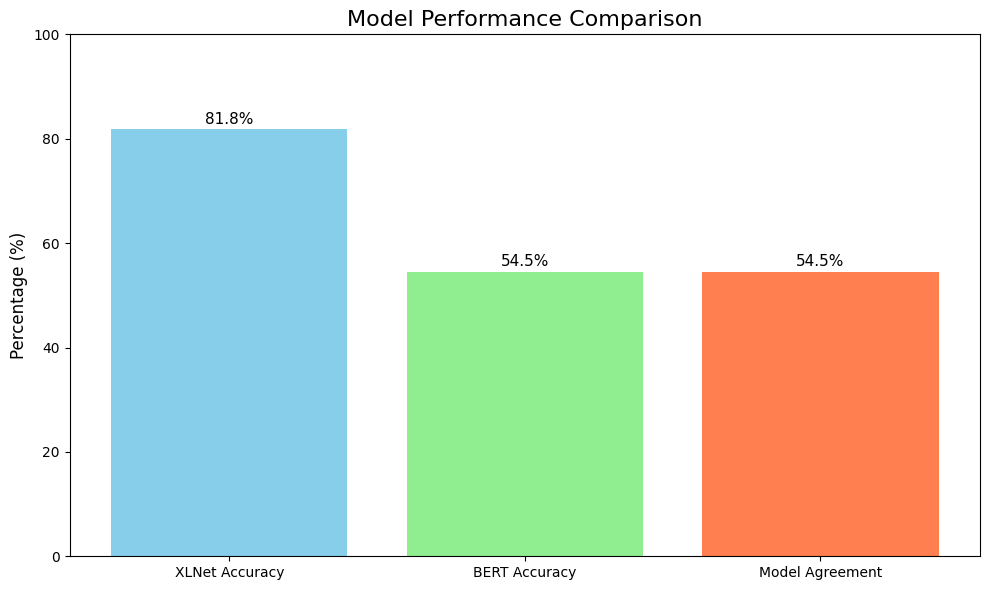

This chart compares the overall accuracy of XLNet and BERT models along with their agreement rate.
Higher bars indicate better performance. The agreement rate shows how often both models make the same prediction.
A model with higher accuracy is more reliable at correctly identifying fraud and non-fraud calls.
--------------------------------------------------------------------------------


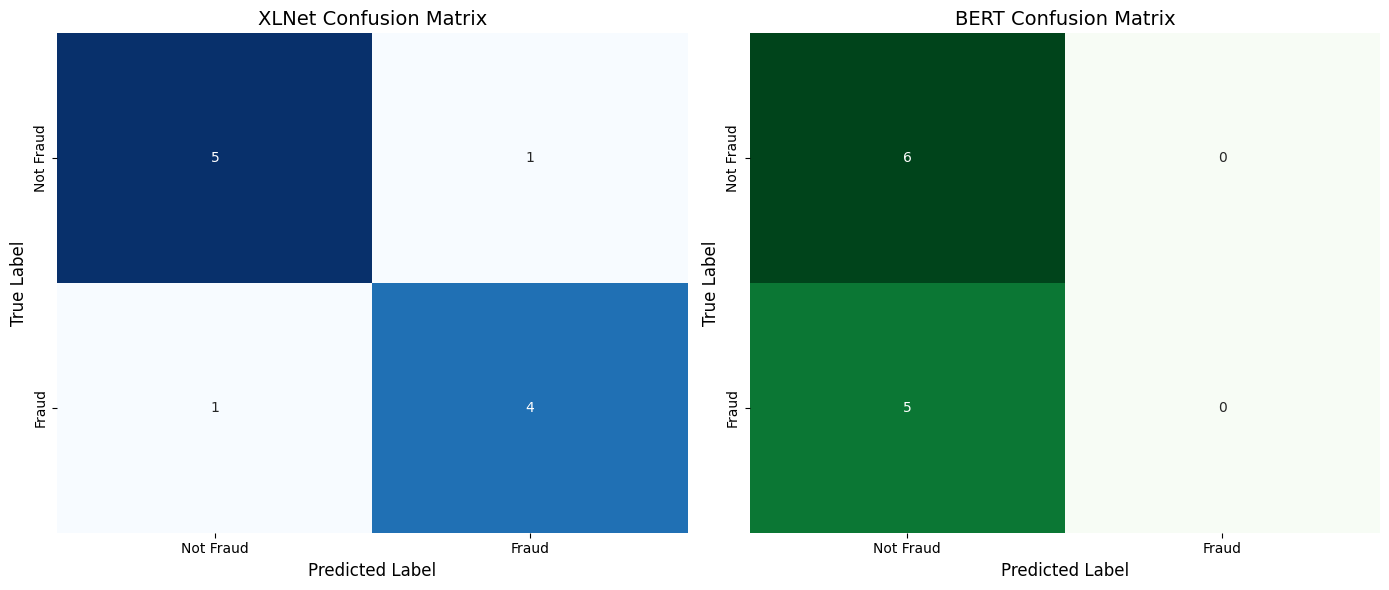

Confusion matrices show the distribution of predictions versus actual labels:
- Top-left: True Negatives (correctly identified non-fraud calls)
- Top-right: False Positives (non-fraud calls incorrectly labeled as fraud)
- Bottom-left: False Negatives (fraud calls incorrectly labeled as non-fraud)
- Bottom-right: True Positives (correctly identified fraud calls)
A good model maximizes values on the diagonal (true positives and true negatives).
--------------------------------------------------------------------------------


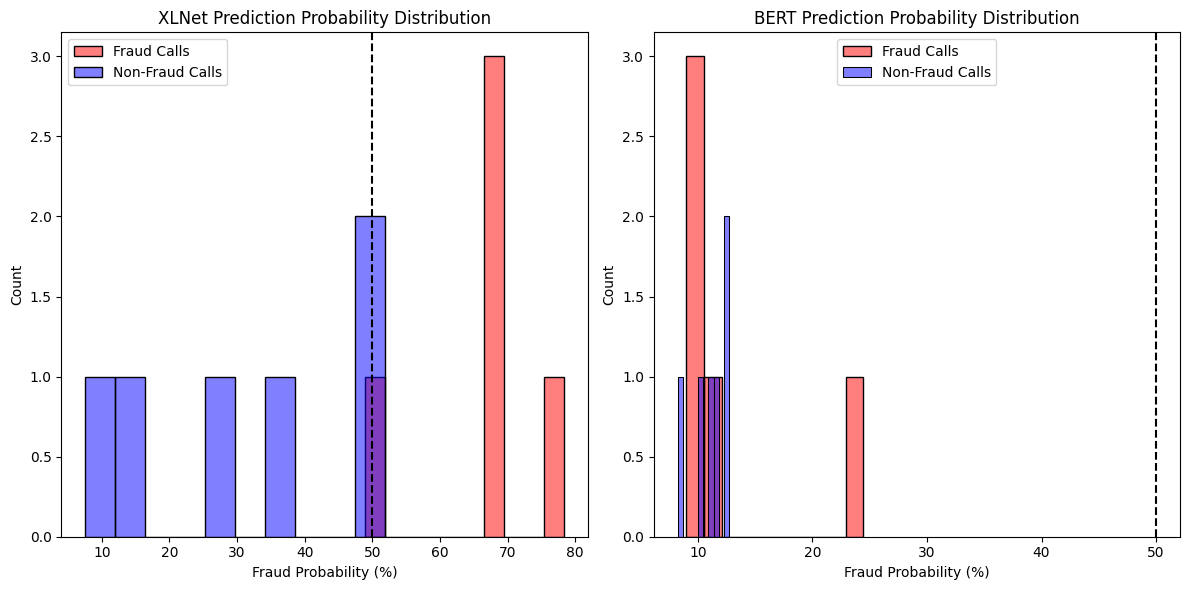

These histograms show how each model assigns fraud probabilities to both fraud and non-fraud calls:
- Red bars represent actual fraud calls
- Blue bars represent actual non-fraud calls
- The vertical dotted line is the 50% decision threshold
Ideally, blue bars should be concentrated on the left (low probability) and red bars on the right (high probability).
The more separation between red and blue distributions, the better the model is at distinguishing fraud from non-fraud.
--------------------------------------------------------------------------------


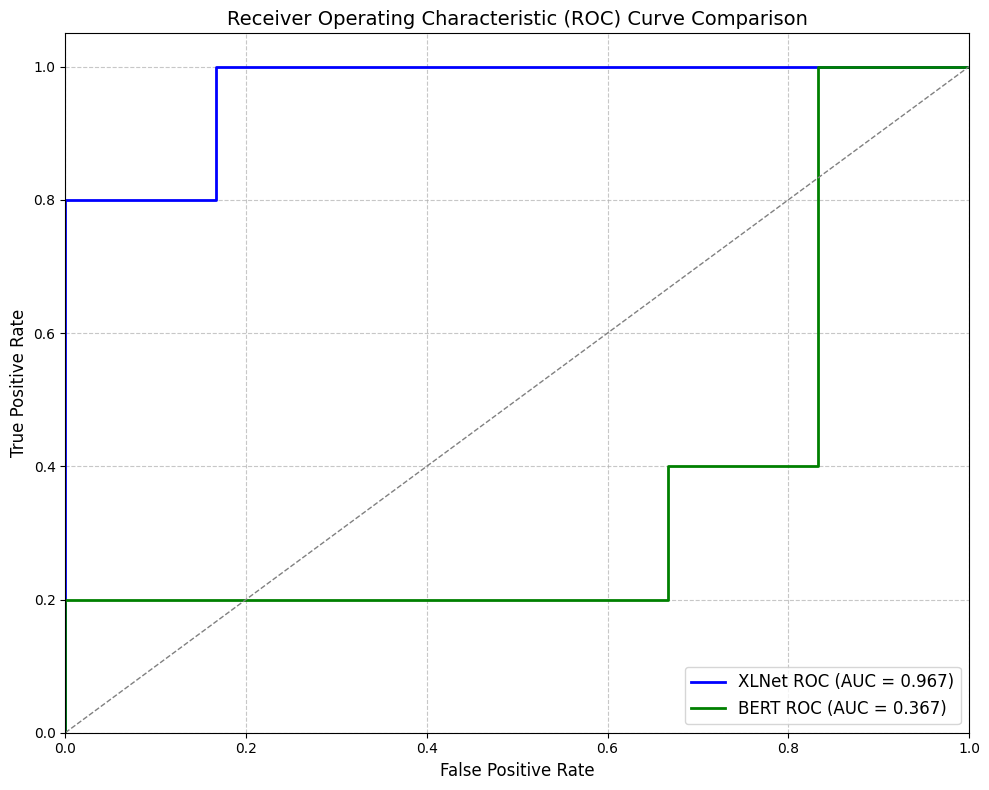

The ROC curves show the trade-off between true positive rate (sensitivity) and false positive rate (1-specificity):
- The diagonal gray dashed line represents a random classifier (AUC = 0.5)
- The closer the curve is to the top-left corner, the better the model's performance
- The Area Under the Curve (AUC) quantifies the overall ability of the model to discriminate between classes
- AUC ranges from 0.5 (no discrimination) to 1.0 (perfect discrimination)
The model with the higher AUC has better overall discriminative ability regardless of threshold choice.
--------------------------------------------------------------------------------


,Metric,XLNet,BERT
0,Accuracy,0.8182,0.5455
1,Precision,0.8000,0.0000
2,Recall,0.8000,0.0000
3,F1 Score,0.8000,0.0000



This table provides a comprehensive comparison of model performance metrics:
- Accuracy: Overall proportion of correct predictions (both fraud and non-fraud)
- Precision: Of all calls predicted as fraud, what percentage were actually fraud (reduces false positives)
- Recall: Of all actual fraud calls, what percentage were correctly identified (reduces false negatives)
- F1 Score: Harmonic mean of precision and recall (balances both false positives and false negatives)

Higher values for all metrics indicate better performance. When evaluating fraud detection systems:
- High precision means fewer false fraud accusations
- High recall means fewer missed fraud cases
- F1 score helps balance these considerations when one can't be optimized without sacrificing the other
--------------------------------------------------------------------------------

Model Selection Recommendation:
XLNet appears to be the better model overall, with stronger recall than precision.
This model is better at re

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
from sklearn.metrics import confusion_matrix

# Create directory for model evaluation visualizations
os.makedirs('model_evaluation_results', exist_ok=True)

def visualize_model_metrics():
    """Generate visualization for model comparison metrics"""
    # Collect results from both models
    xlnet_results = {}
    bert_results = {}
    actual_labels = {}

    # Process XLNet predictions
    for filename in sorted(os.listdir("./Predictions")):
        base_name = filename.split('.')[0]
        actual_type = 1 if '-' in base_name else 0  # 1 for fraud, 0 for not fraud
        actual_labels[base_name] = actual_type

        with open(f'./Predictions/{filename}', 'r') as f:
            probability = float(f.read().strip())
            xlnet_results[base_name] = probability

    # Process BERT predictions
    for filename in sorted(os.listdir("./Predictions_BERT")):
        base_name = filename.split('.')[0].replace('.bert', '')

        with open(f'./Predictions_BERT/{filename}', 'r') as f:
            probability = float(f.read().strip())
            bert_results[base_name] = probability

    # Create dataframe for visualization
    results_df = pd.DataFrame({
        'filename': list(actual_labels.keys()),
        'actual': list(actual_labels.values()),
        'xlnet_prob': [xlnet_results.get(k, 0) for k in actual_labels.keys()],
        'bert_prob': [bert_results.get(k, 0) for k in actual_labels.keys()]
    })

    # Add predicted labels
    results_df['xlnet_pred'] = (results_df['xlnet_prob'] > 50).astype(int)
    results_df['bert_pred'] = (results_df['bert_prob'] > 50).astype(int)

    # Calculate agreement
    results_df['agreement'] = (results_df['xlnet_pred'] == results_df['bert_pred']).astype(int)

    # 1. Overall Accuracy Comparison
    plt.figure(figsize=(10, 6))

    xlnet_accuracy = (results_df['xlnet_pred'] == results_df['actual']).mean() * 100
    bert_accuracy = (results_df['bert_pred'] == results_df['actual']).mean() * 100
    agreement_rate = results_df['agreement'].mean() * 100

    metrics = ['XLNet Accuracy', 'BERT Accuracy', 'Model Agreement']
    values = [xlnet_accuracy, bert_accuracy, agreement_rate]

    bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'coral'])
    plt.ylim(0, 100)
    plt.title('Model Performance Comparison', fontsize=16)
    plt.ylabel('Percentage (%)', fontsize=12)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', fontsize=11)

    plt.tight_layout()
    plt.savefig('model_evaluation_results/model_accuracy_comparison.png')
    plt.close()

    # 2. Confusion Matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # XLNet Confusion Matrix
    cm_xlnet = confusion_matrix(results_df['actual'], results_df['xlnet_pred'])
    sns.heatmap(cm_xlnet, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1)
    ax1.set_title('XLNet Confusion Matrix', fontsize=14)
    ax1.set_xlabel('Predicted Label', fontsize=12)
    ax1.set_ylabel('True Label', fontsize=12)
    ax1.set_xticklabels(['Not Fraud', 'Fraud'])
    ax1.set_yticklabels(['Not Fraud', 'Fraud'])

    # BERT Confusion Matrix
    cm_bert = confusion_matrix(results_df['actual'], results_df['bert_pred'])
    sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens', cbar=False, ax=ax2)
    ax2.set_title('BERT Confusion Matrix', fontsize=14)
    ax2.set_xlabel('Predicted Label', fontsize=12)
    ax2.set_ylabel('True Label', fontsize=12)
    ax2.set_xticklabels(['Not Fraud', 'Fraud'])
    ax2.set_yticklabels(['Not Fraud', 'Fraud'])

    plt.tight_layout()
    plt.savefig('model_evaluation_results/confusion_matrices.png')
    plt.close()

    # 3. Prediction Probability Distribution
    plt.figure(figsize=(12, 6))

    # Fraud cases
    fraud_cases = results_df[results_df['actual'] == 1]
    non_fraud_cases = results_df[results_df['actual'] == 0]

    # Plot XLNet probabilities
    plt.subplot(1, 2, 1)
    sns.histplot(fraud_cases['xlnet_prob'], color='red', alpha=0.5, bins=10, label='Fraud Calls')
    sns.histplot(non_fraud_cases['xlnet_prob'], color='blue', alpha=0.5, bins=10, label='Non-Fraud Calls')
    plt.axvline(x=50, color='black', linestyle='--')
    plt.title('XLNet Prediction Probability Distribution', fontsize=12)
    plt.xlabel('Fraud Probability (%)', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.legend()

    # Plot BERT probabilities
    plt.subplot(1, 2, 2)
    sns.histplot(fraud_cases['bert_prob'], color='red', alpha=0.5, bins=10, label='Fraud Calls')
    sns.histplot(non_fraud_cases['bert_prob'], color='blue', alpha=0.5, bins=10, label='Non-Fraud Calls')
    plt.axvline(x=50, color='black', linestyle='--')
    plt.title('BERT Prediction Probability Distribution', fontsize=12)
    plt.xlabel('Fraud Probability (%)', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.legend()

    plt.tight_layout()
    plt.savefig('model_evaluation_results/probability_distribution.png')
    plt.close()

    # 4. Model Disagreement Analysis
    disagreement_cases = results_df[results_df['agreement'] == 0]

    if len(disagreement_cases) > 0:
        plt.figure(figsize=(10, 6))

        # For each disagreement case, show the prediction probabilities
        case_names = [f"Case {i+1}" for i in range(len(disagreement_cases))]

        x = np.arange(len(case_names))
        width = 0.35

        plt.bar(x - width/2, disagreement_cases['xlnet_prob'], width, label='XLNet Probability', color='skyblue')
        plt.bar(x + width/2, disagreement_cases['bert_prob'], width, label='BERT Probability', color='lightgreen')

        plt.axhline(y=50, color='red', linestyle='--', label='Decision Threshold')
        plt.xlabel('Disagreement Cases', fontsize=12)
        plt.ylabel('Fraud Probability (%)', fontsize=12)
        plt.title('Model Disagreement Analysis', fontsize=14)
        plt.xticks(x, case_names)
        plt.legend()

        plt.tight_layout()
        plt.savefig('model_evaluation_results/disagreement_analysis.png')
        plt.close()

    # 5. Performance metrics table
    from sklearn.metrics import precision_score, recall_score, f1_score

    # Calculate metrics
    xlnet_precision = precision_score(results_df['actual'], results_df['xlnet_pred'], zero_division=0)
    xlnet_recall = recall_score(results_df['actual'], results_df['xlnet_pred'], zero_division=0)
    xlnet_f1 = f1_score(results_df['actual'], results_df['xlnet_pred'], zero_division=0)

    bert_precision = precision_score(results_df['actual'], results_df['bert_pred'], zero_division=0)
    bert_recall = recall_score(results_df['actual'], results_df['bert_pred'], zero_division=0)
    bert_f1 = f1_score(results_df['actual'], results_df['bert_pred'], zero_division=0)

    # Create metrics table
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'XLNet': [xlnet_accuracy/100, xlnet_precision, xlnet_recall, xlnet_f1],
        'BERT': [bert_accuracy/100, bert_precision, bert_recall, bert_f1]
    })

    # Plot as table
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.axis('tight')
    ax.axis('off')

    # Create the table
    table = ax.table(
        cellText=metrics_df.values,
        colLabels=metrics_df.columns,
        cellLoc='center',
        loc='center',
        colColours=['#f2f2f2', '#d9e9f7', '#d9f0d6']
    )

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)

    plt.title('Performance Metrics Comparison', fontsize=16, pad=20)
    plt.tight_layout()
    plt.savefig('model_evaluation_results/metrics_table.png')
    plt.close()

    # 6. ROC Curve comparison
    from sklearn.metrics import roc_curve, auc

    plt.figure(figsize=(10, 8))

    # XLNet ROC
    fpr_xlnet, tpr_xlnet, _ = roc_curve(results_df['actual'], results_df['xlnet_prob']/100)
    roc_auc_xlnet = auc(fpr_xlnet, tpr_xlnet)

    # BERT ROC
    fpr_bert, tpr_bert, _ = roc_curve(results_df['actual'], results_df['bert_prob']/100)
    roc_auc_bert = auc(fpr_bert, tpr_bert)

    # Plot both curves
    plt.plot(fpr_xlnet, tpr_xlnet, color='blue', lw=2,
             label=f'XLNet ROC (AUC = {roc_auc_xlnet:.3f})')
    plt.plot(fpr_bert, tpr_bert, color='green', lw=2,
             label=f'BERT ROC (AUC = {roc_auc_bert:.3f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve Comparison', fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('model_evaluation_results/roc_curve.png')
    plt.close()

    # Return dataframe for additional analysis
    return results_df

def display_model_evaluation():
    """Display model evaluation visualizations directly in the notebook"""
    results_df = visualize_model_metrics()

    # Calculate metrics
    xlnet_accuracy = (results_df['xlnet_pred'] == results_df['actual']).mean() * 100
    bert_accuracy = (results_df['bert_pred'] == results_df['actual']).mean() * 100
    agreement_rate = results_df['agreement'].mean() * 100

    # Print summary metrics
    print("=" * 50)
    print("FRAUD DETECTION MODEL COMPARISON")
    print("=" * 50)
    print(f"XLNet Accuracy: {xlnet_accuracy:.2f}%")
    print(f"BERT Accuracy: {bert_accuracy:.2f}%")
    print(f"Model Agreement Rate: {agreement_rate:.2f}%")
    print("=" * 50)

    # Display all visualizations in notebook
    # Note: The files are still saved, but now we also display them

    # 1. Display accuracy comparison
    plt.figure(figsize=(10, 6))

    metrics = ['XLNet Accuracy', 'BERT Accuracy', 'Model Agreement']
    values = [xlnet_accuracy, bert_accuracy, agreement_rate]

    bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'coral'])
    plt.ylim(0, 100)
    plt.title('Model Performance Comparison', fontsize=16)
    plt.ylabel('Percentage (%)', fontsize=12)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', fontsize=11)

    plt.tight_layout()
    plt.show()

    # Add explanation
    print("This chart compares the overall accuracy of XLNet and BERT models along with their agreement rate.")
    print("Higher bars indicate better performance. The agreement rate shows how often both models make the same prediction.")
    print("A model with higher accuracy is more reliable at correctly identifying fraud and non-fraud calls.")
    print("-" * 80)

    # 2. Display confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # XLNet Confusion Matrix
    cm_xlnet = confusion_matrix(results_df['actual'], results_df['xlnet_pred'])
    sns.heatmap(cm_xlnet, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1)
    ax1.set_title('XLNet Confusion Matrix', fontsize=14)
    ax1.set_xlabel('Predicted Label', fontsize=12)
    ax1.set_ylabel('True Label', fontsize=12)
    ax1.set_xticklabels(['Not Fraud', 'Fraud'])
    ax1.set_yticklabels(['Not Fraud', 'Fraud'])

    # BERT Confusion Matrix
    cm_bert = confusion_matrix(results_df['actual'], results_df['bert_pred'])
    sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens', cbar=False, ax=ax2)
    ax2.set_title('BERT Confusion Matrix', fontsize=14)
    ax2.set_xlabel('Predicted Label', fontsize=12)
    ax2.set_ylabel('True Label', fontsize=12)
    ax2.set_xticklabels(['Not Fraud', 'Fraud'])
    ax2.set_yticklabels(['Not Fraud', 'Fraud'])

    plt.tight_layout()
    plt.show()

    # Add explanation
    print("Confusion matrices show the distribution of predictions versus actual labels:")
    print("- Top-left: True Negatives (correctly identified non-fraud calls)")
    print("- Top-right: False Positives (non-fraud calls incorrectly labeled as fraud)")
    print("- Bottom-left: False Negatives (fraud calls incorrectly labeled as non-fraud)")
    print("- Bottom-right: True Positives (correctly identified fraud calls)")
    print("A good model maximizes values on the diagonal (true positives and true negatives).")
    print("-" * 80)

    # 3. Display prediction probability distribution
    plt.figure(figsize=(12, 6))

    # Fraud cases
    fraud_cases = results_df[results_df['actual'] == 1]
    non_fraud_cases = results_df[results_df['actual'] == 0]

    # Plot XLNet probabilities
    plt.subplot(1, 2, 1)
    sns.histplot(fraud_cases['xlnet_prob'], color='red', alpha=0.5, bins=10, label='Fraud Calls')
    sns.histplot(non_fraud_cases['xlnet_prob'], color='blue', alpha=0.5, bins=10, label='Non-Fraud Calls')
    plt.axvline(x=50, color='black', linestyle='--')
    plt.title('XLNet Prediction Probability Distribution', fontsize=12)
    plt.xlabel('Fraud Probability (%)', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.legend()

    # Plot BERT probabilities
    plt.subplot(1, 2, 2)
    sns.histplot(fraud_cases['bert_prob'], color='red', alpha=0.5, bins=10, label='Fraud Calls')
    sns.histplot(non_fraud_cases['bert_prob'], color='blue', alpha=0.5, bins=10, label='Non-Fraud Calls')
    plt.axvline(x=50, color='black', linestyle='--')
    plt.title('BERT Prediction Probability Distribution', fontsize=12)
    plt.xlabel('Fraud Probability (%)', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Add explanation
    print("These histograms show how each model assigns fraud probabilities to both fraud and non-fraud calls:")
    print("- Red bars represent actual fraud calls")
    print("- Blue bars represent actual non-fraud calls")
    print("- The vertical dotted line is the 50% decision threshold")
    print("Ideally, blue bars should be concentrated on the left (low probability) and red bars on the right (high probability).")
    print("The more separation between red and blue distributions, the better the model is at distinguishing fraud from non-fraud.")
    print("-" * 80)

    # 4. Display ROC Curve comparison
    from sklearn.metrics import roc_curve, auc

    plt.figure(figsize=(10, 8))

    # XLNet ROC
    fpr_xlnet, tpr_xlnet, _ = roc_curve(results_df['actual'], results_df['xlnet_prob']/100)
    roc_auc_xlnet = auc(fpr_xlnet, tpr_xlnet)

    # BERT ROC
    fpr_bert, tpr_bert, _ = roc_curve(results_df['actual'], results_df['bert_prob']/100)
    roc_auc_bert = auc(fpr_bert, tpr_bert)

    # Plot both curves
    plt.plot(fpr_xlnet, tpr_xlnet, color='blue', lw=2,
             label=f'XLNet ROC (AUC = {roc_auc_xlnet:.3f})')
    plt.plot(fpr_bert, tpr_bert, color='green', lw=2,
             label=f'BERT ROC (AUC = {roc_auc_bert:.3f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve Comparison', fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Add explanation
    print("The ROC curves show the trade-off between true positive rate (sensitivity) and false positive rate (1-specificity):")
    print("- The diagonal gray dashed line represents a random classifier (AUC = 0.5)")
    print("- The closer the curve is to the top-left corner, the better the model's performance")
    print("- The Area Under the Curve (AUC) quantifies the overall ability of the model to discriminate between classes")
    print("- AUC ranges from 0.5 (no discrimination) to 1.0 (perfect discrimination)")
    print("The model with the higher AUC has better overall discriminative ability regardless of threshold choice.")
    print("-" * 80)

    # 5. Display Performance Metrics Table
    from sklearn.metrics import precision_score, recall_score, f1_score

    # Calculate metrics
    xlnet_precision = precision_score(results_df['actual'], results_df['xlnet_pred'], zero_division=0)
    xlnet_recall = recall_score(results_df['actual'], results_df['xlnet_pred'], zero_division=0)
    xlnet_f1 = f1_score(results_df['actual'], results_df['xlnet_pred'], zero_division=0)

    bert_precision = precision_score(results_df['actual'], results_df['bert_pred'], zero_division=0)
    bert_recall = recall_score(results_df['actual'], results_df['bert_pred'], zero_division=0)
    bert_f1 = f1_score(results_df['actual'], results_df['bert_pred'], zero_division=0)

    # Create a DataFrame for display
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'XLNet': [xlnet_accuracy/100, xlnet_precision, xlnet_recall, xlnet_f1],
        'BERT': [bert_accuracy/100, bert_precision, bert_recall, bert_f1]
    })

    # Display the DataFrame as a table
    from IPython.display import display
    display(metrics_df.style.format({
        'XLNet': '{:.4f}',
        'BERT': '{:.4f}'
    }).set_caption('Performance Metrics Comparison'))

    # Add explanation
    print("\nThis table provides a comprehensive comparison of model performance metrics:")
    print("- Accuracy: Overall proportion of correct predictions (both fraud and non-fraud)")
    print("- Precision: Of all calls predicted as fraud, what percentage were actually fraud (reduces false positives)")
    print("- Recall: Of all actual fraud calls, what percentage were correctly identified (reduces false negatives)")
    print("- F1 Score: Harmonic mean of precision and recall (balances both false positives and false negatives)")
    print("\nHigher values for all metrics indicate better performance. When evaluating fraud detection systems:")
    print("- High precision means fewer false fraud accusations")
    print("- High recall means fewer missed fraud cases")
    print("- F1 score helps balance these considerations when one can't be optimized without sacrificing the other")
    print("-" * 80)

    # 6. Add a model selection recommendation
    print("\nModel Selection Recommendation:")
    if xlnet_f1 > bert_f1:
        if xlnet_precision > xlnet_recall:
            print("XLNet appears to be the better model overall, with stronger precision than recall.")
            print("This model is better at reducing false positives (wrongly flagging normal calls as fraud).")
        else:
            print("XLNet appears to be the better model overall, with stronger recall than precision.")
            print("This model is better at reducing false negatives (missing actual fraud calls).")
    else:
        if bert_precision > bert_recall:
            print("BERT appears to be the better model overall, with stronger precision than recall.")
            print("This model is better at reducing false positives (wrongly flagging normal calls as fraud).")
        else:
            print("BERT appears to be the better model overall, with stronger recall than precision.")
            print("This model is better at reducing false negatives (missing actual fraud calls).")

    # Add application-specific recommendation
    print("\nFor fraud detection in call centers:")
    if max(xlnet_recall, bert_recall) > max(xlnet_precision, bert_precision):
        print("The model with higher recall would be preferable if the cost of missing fraud is high.")
        print("This is often the case in financial institutions where undetected fraud can be very costly.")
    else:
        print("The model with higher precision would be preferable if the cost of false alarms is high.")
        print("This is often the case when investigation resources are limited or each false alarm has significant costs.")

# Run the evaluation with display
if __name__ == "__main__":
    display_model_evaluation()